In [2]:
import numpy as np  
import matplotlib.pyplot as plt 
import scipy.signal as sp
import numpy.linalg as nplin
from gekko import GEKKO

from scipy.integrate import odeint
from scipy.signal import place_poles
from scipy.signal import find_peaks
from scipy.linalg import solve_continuous_are


from plotfunc import plot_sets

In [ ]:
R=0.5
L=0.5
C=0.2

A=np.array([[0,1],[-1/(L*C),-R/L]])
B=np.array([[0],[1/L]])

Q=np.array([[1,0],
            [0,1]])

R=np.array([[1]])

P = solve_continuous_are(A, B, Q, R)

print(f"Macierz P:")
print(P)

Macierz P:
[[3.42237346 0.04950976]
 [0.04950976 0.3307365 ]]


In [6]:
R_inv = np.linalg.inv(R) # Odwrotność macierzy R
K = R_inv @ B.T @ P

print("\nMacierz Wzmocnień K:")
print(K)


Macierz Wzmocnień K:
[[0.09901951 0.66147299]]


In [15]:
def model(x,t):
    R=0.5
    L=0.5
    C=0.2
    u=np.array([[1]])

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])

    dx=A@x+(B*u).flatten()
    return dx

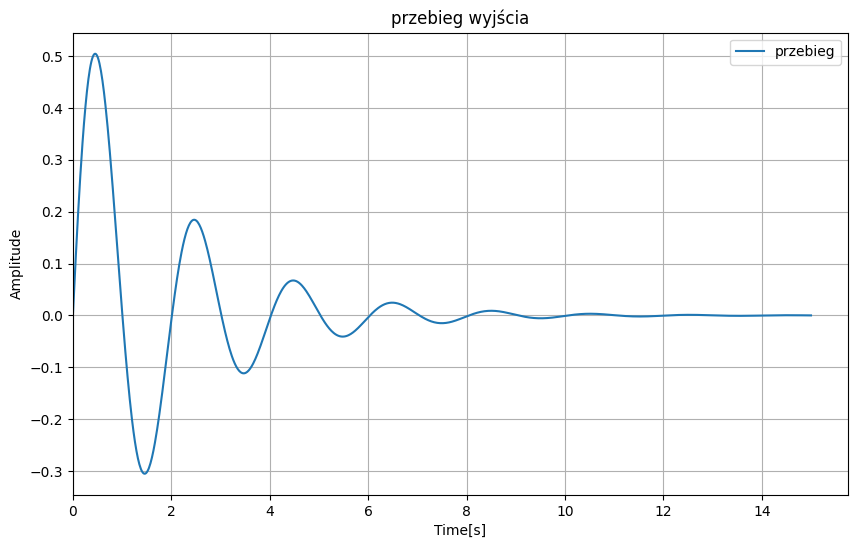

In [21]:
x0 = np.array([0, 0])

t = np.linspace(0, 15, 1000)

x = odeint(model, x0, t)

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [24]:
def model_with_K(x,t,K):
    R=0.5
    L=0.5
    C=0.2
    u=-K@x

    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])
    
    dx=A@x+(B*u).flatten()
    return dx

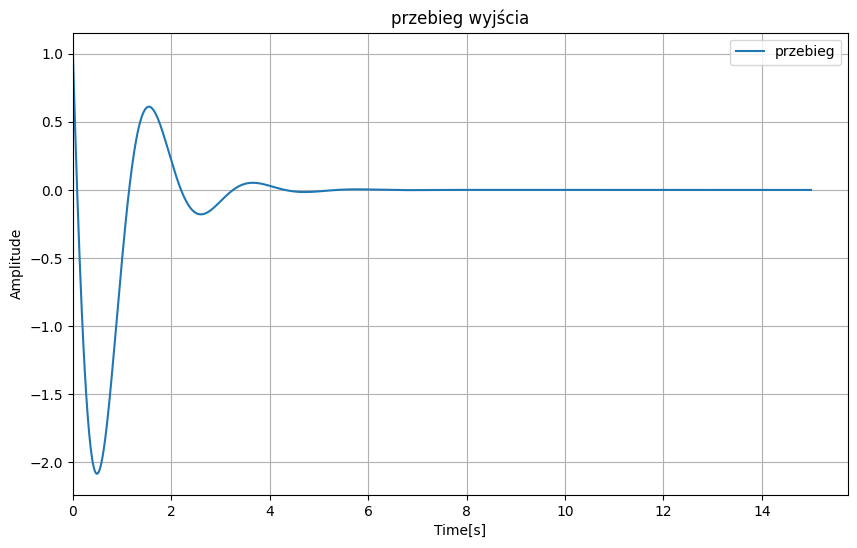

In [27]:
x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x = odeint(model_with_K, x0, t,args=(K,))

y = x[:, 1]
plot_sets('przebieg wyjścia',[t,y,'przebieg'])

In [ ]:
R1=np.array([[1]])
Q1=np.array([[10,0],
             [0,10]])

P1 = solve_continuous_are(A, B, Q1, R1)
R1_inv = np.linalg.inv(R1) 
K1 = R1_inv @ B.T @ P1

R2=np.array([[10]])
Q2=np.array([[1,0],
             [0,1]])

P2 = solve_continuous_are(A, B, Q2, R2)
R2_inv = np.linalg.inv(R2) 
K2 = R2_inv @ B.T @ P2

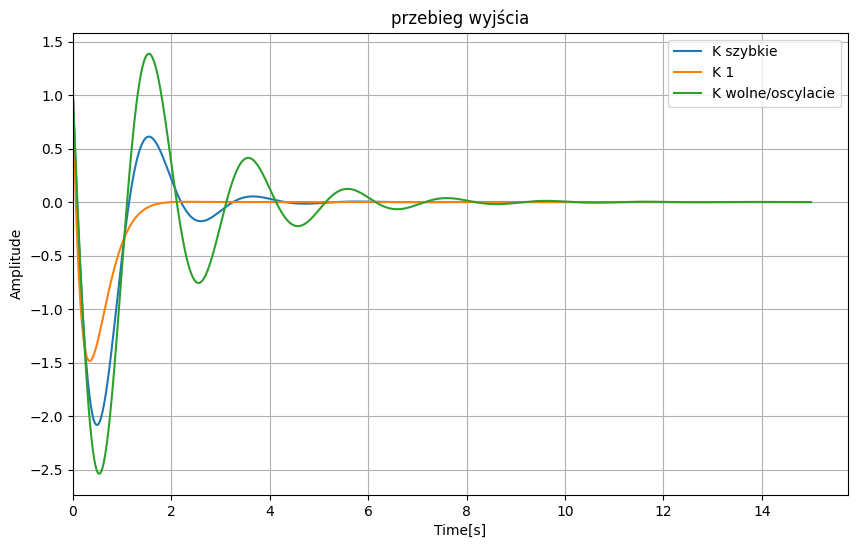

In [ ]:

x0 = np.array([1, 1])

t = np.linspace(0, 15, 1000)

x1 = odeint(model_with_K, x0, t,args=(K,))
x2=odeint(model_with_K, x0, t,args=(K1,))
x3=odeint(model_with_K, x0, t,args=(K2,))


y1 = x1[:, 1]
y2 = x2[:, 1]
y3 = x3[:, 1]

plot_sets('przebieg wyjścia',[t,y1,'K szybkie'],
          [t,y2,'K 1'],
          [t,y3,'K wolne/oscylacie'])

In [ ]:

def model_cost_function(x_roz, t, K, Q, R):
    R=0.5
    L=0.5
    C=0.2
    A=np.array([[0,1],[-1/(L*C),-R/L]])
    B=np.array([[0],[1/L]])
    
    x = x_roz[:2] 
    
    # Sygnał sterujący: u = -Kx (skalar)
    u = -K @ x 
    
    # Równania dynamiki (x_dot)
    x_dot_1 = x[1]
    x_dot_2 = -10.0 * x[0] - 2.5 * x[1] + 5.0 * u
    
    # Wyrażenie podcałkowe wskaźnika J: x^T * Q * x + u^T * R * u
    x_vec = x.reshape(2, 1) # Kolumnowy wektor stanu
    u_mat = np.array([[u]]) # Macierz 1x1 dla u
    
    cost_integrand = x_vec.T @ Q @ x_vec + u_mat.T @ R @ u_mat
    
    # Wektor pochodnych
    x_dot_nominal = np.array([x_dot_1, x_dot_2])
    
    return np.concatenate((x_dot_nominal, cost_integrand.flatten()))

In [35]:
x0 = np.array([1, 1, 0])

t = np.linspace(0, 15, 1000)

sol_LQR = odeint(model_cost_function, x0, t, args=(K, Q, R))
J_LQR = sol_LQR[-1, 2] # Wartość J_akum w ostatniej chwili

# Symulacja dla innych wzmocnień (nieoptymalne)
sol_Inne = odeint(model_cost_function, x0, t, args=(K1, Q1, R1))
J_Inne = sol_Inne[-1, 2]

print(f"Wartość wskaźnika J dla wzmocnień LQR: {J_LQR:.4f}")
print(f"Wartość wskaźnika J dla innych wzmocnień: {J_Inne:.4f}")

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)